In [31]:
import pandas as pd
df = pd.read_csv('../Data/reviews_with_sentiment.csv')
print(df.head())

   overall                                         reviewText        asin  \
0        5  I don't spend a lot on my flags because they r...  9539723809   
1        5  Super fast processing and shipping, if you are...  9539723809   
2        5  Great product.  I would recommend this product...  9539723809   
3        5            GREAT PRICE I LOVE MY STATE AND COUNTRY  9539723809   
4        5                    Great display flag for the den.  9539723809   

   sentiment  
0     0.9514  
1     0.8748  
2     0.8442  
3     0.8519  
4     0.6249  


In [32]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [33]:
def catagorise_data(sentiment):
    if sentiment >=-1 and sentiment < -0.5:
        return 1
    
    if sentiment >= -0.5 and sentiment < 0:
        return 2
    
    if sentiment == 0:
        return 3
    
    if sentiment > 0 and sentiment < 0.5:
        return 4
    
    if sentiment >= 0.5 and sentiment <= 1:
        return 5

In [34]:
newReviews = []
for i in tqdm(range(len(df))):
    ss = df.iloc[i]['sentiment']
    newReviews.append(catagorise_data(ss))

100%|███████████████████████████████████████████████████████████████████████| 798229/798229 [00:55<00:00, 14315.47it/s]


In [35]:
df['new_overall'] = newReviews

In [36]:
df.head()

,overall,reviewText,asin,sentiment,new_overall
0,5,I don't spend a lot on my flags because they r...,9539723809,0.9514,5
1,5,"Super fast processing and shipping, if you are...",9539723809,0.8748,5
2,5,Great product. I would recommend this product...,9539723809,0.8442,5
3,5,GREAT PRICE I LOVE MY STATE AND COUNTRY,9539723809,0.8519,5
4,5,Great display flag for the den.,9539723809,0.6249,5


In [37]:
original = df["overall"].value_counts()
new_scores = df['new_overall'].value_counts()

In [38]:
original.head()

5    533459
4    123368
3     57468
1     51545
2     32389
Name: overall, dtype: int64

In [39]:
new_scores

5    451322
4    162412
3     81584
2     58593
1     44318
Name: new_overall, dtype: int64

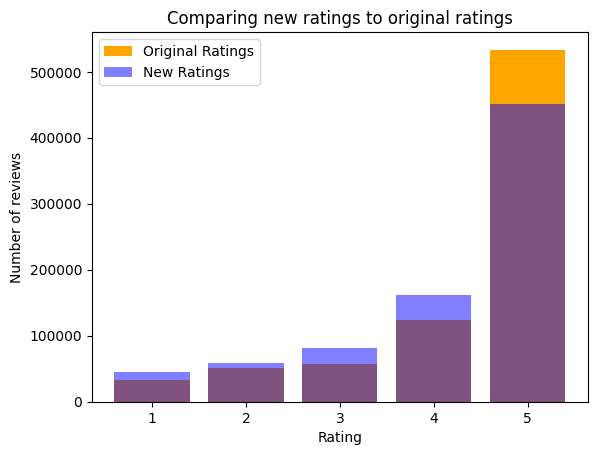

In [40]:
fig, ax = plt.subplots()

# Plot the first bar chart
ax.bar([5,4,3,2,1], original, label='Original Ratings', color='orange')

# Plot the second bar chart on top of the first one
ax.bar([5,4,3,2,1], new_scores, label='New Ratings', color='blue', alpha=0.5)

ax.set_xlabel('Rating')
ax.set_ylabel('Number of reviews')
ax.set_title('Comparing new ratings to original ratings')
ax.legend()

plt.show()

In [41]:
five_stars = df[(df['overall'] == 5)]
redistributedFiveStars = five_stars['new_overall'].value_counts()
total = redistributedFiveStars.sum()
print(redistributedFiveStars, '\n', redistributedFiveStars.sum(), '\n')
for i in range(1, 6):
    redistributedFiveStars[i] /= total
print(redistributedFiveStars,'\n', redistributedFiveStars.sum())

5    352229
4    100129
3     46940
2     20727
1     13434
Name: new_overall, dtype: int64 
 533459 

5    0.660274
4    0.187698
3    0.087992
2    0.038854
1    0.025183
Name: new_overall, dtype: float64 
 1.0


In [42]:
four_stars = df[(df['overall'] == 4)]
redistributedFourStars = four_stars['new_overall'].value_counts()
total = redistributedFourStars.sum()
print(redistributedFourStars, '\n', redistributedFourStars.sum(), '\n')
for i in range(1, 6):
    redistributedFourStars[i] /= total
print(redistributedFourStars,'\n', redistributedFourStars.sum())

5    64354
4    32259
3    12204
2     8876
1     5675
Name: new_overall, dtype: int64 
 123368 

5    0.521643
4    0.261486
3    0.098924
2    0.071947
1    0.046001
Name: new_overall, dtype: float64 
 1.0


In [43]:
three_stars = df[(df['overall'] == 3)]
redistributedThreeStars = three_stars['new_overall'].value_counts()
total = redistributedThreeStars.sum()
print(redistributedThreeStars, '\n', redistributedThreeStars.sum(), '\n')
for i in range(1, 6):
    redistributedThreeStars[i] /= total
print(redistributedThreeStars,'\n', redistributedThreeStars.sum())

5    18783
4    15042
2     9523
3     7994
1     6126
Name: new_overall, dtype: int64 
 57468 

5    0.326843
4    0.261746
2    0.165710
3    0.139104
1    0.106598
Name: new_overall, dtype: float64 
 0.9999999999999999


In [44]:
two_stars = df[(df['overall'] == 2)]
redistributedTwoStars = two_stars['new_overall'].value_counts()
total = redistributedTwoStars.sum()
print(redistributedTwoStars, '\n', redistributedTwoStars.sum(), '\n')
for i in range(1, 6):
    redistributedTwoStars[i] /= total
print(redistributedTwoStars,'\n', redistributedTwoStars.sum())

2    7436
5    7400
4    6581
1    6010
3    4962
Name: new_overall, dtype: int64 
 32389 

2    0.229584
5    0.228473
4    0.203186
1    0.185557
3    0.153200
Name: new_overall, dtype: float64 
 1.0


In [45]:
one_star = df[(df['overall'] == 1)]
redistributedOneStar = one_star['new_overall'].value_counts()
total = redistributedOneStar.sum()
print(redistributedOneStar, '\n', redistributedOneStar.sum(), '\n')
for i in range(1, 6):
    redistributedOneStar[i] /= total
print(redistributedOneStar,'\n', redistributedOneStar.sum())

1    13073
2    12031
3     9484
5     8556
4     8401
Name: new_overall, dtype: int64 
 51545 

1    0.253623
2    0.233408
3    0.183995
5    0.165991
4    0.162984
Name: new_overall, dtype: float64 
 1.0


In [48]:

print(productItems)
print(len(productItems))

['9539723809' 'B00000JSZH' 'B0000224PU' ... 'B01H1OSPMM' 'B01H54DOQA'
 'B01H6O0UP2']
32918


In [58]:
productItems = df['asin'].unique()
compareAverage = pd.DataFrame({
    'productId' :[],
    'originalAverage' :[],
    'newAverage' :[]
})
for curItem in tqdm(productItems):
    itemScores = df[(df['asin'] == curItem)]
    new_row = pd.Series({'productId':curItem, 
                         'originalAverage': itemScores['overall'].mean(), 
                         'newAverage': itemScores['new_overall'].mean()})
    compareAverage = pd.concat([compareAverage, new_row.to_frame().T], ignore_index=True)


100%|████████████████████████████████████████████████████████████████████████████| 32918/32918 [23:15<00:00, 23.59it/s]


In [59]:
compareAverage.head()

,productId,originalAverage,newAverage
0,9539723809,4.888889,5.0
1,B00000JSZH,4.848485,4.575758
2,B0000224PU,4.833333,4.166667
3,B00002N66T,4.419355,4.225806
4,B00002N66Z,2.428571,2.571429


In [64]:
averageDiff = 0
for i in tqdm(range(len(compareAverage))):
    averageDiff += compareAverage.iloc[i]['originalAverage'] - compareAverage.iloc[i]['newAverage']
    
print(averageDiff/len(compareAverage))

100%|█████████████████████████████████████████████████████████████████████████| 32918/32918 [00:02<00:00, 14143.94it/s]

0.12526335871066538
